In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import matplotlib.pyplot as plt 
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.font_manager as fm

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지

---

## Like Count

### 데이터 불러오기

In [4]:
years20 = pd.read_csv('year2020.csv')
years20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     720 non-null    int64 
 1   song_name   720 non-null    object
 2   artist      720 non-null    object
 3   album       720 non-null    object
 4   Like_Count  720 non-null    object
 5   Lyric       657 non-null    object
 6   cover_url   720 non-null    object
 7   tags        720 non-null    object
 8   year        720 non-null    object
dtypes: int64(1), object(8)
memory usage: 50.8+ KB


In [5]:
years21 = pd.read_csv('year2021.csv')
years21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     705 non-null    int64 
 1   song_name   705 non-null    object
 2   artist      705 non-null    object
 3   album       705 non-null    object
 4   Like_Count  705 non-null    object
 5   Lyric       697 non-null    object
 6   cover_url   705 non-null    object
 7   tags        705 non-null    object
 8   year        705 non-null    object
dtypes: int64(1), object(8)
memory usage: 49.7+ KB


In [6]:
years210 = years20.append(years21)

## 전처리
* Like_Count 괄호 제거
* 숫자형변환

In [11]:
years210.reset_index(drop=True,inplace=True)

In [12]:
years210['Lyric'] = years210['Lyric'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
years210.loc[:0]

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,31904571,에잇(Prod.&Feat. SUGA of BTS),아이유(IU),에잇,"[15,806]",뭐 그대로야 난 다 잃어버린 것 같아 모든 게 맘대로 왔다...,https://image.bugsm.co.kr/album/images/200/203...,"['국내', '가요', '연도별 인기가요', '2020년', '2020년대']",2020y


In [14]:
years210['Lyric'] = years210['Lyric'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
years210['Lyric'].replace('', np.nan, inplace=True)
print(years210.isnull().sum())

song_id         0
song_name       0
artist          0
album           0
Like_Count      0
Lyric         171
cover_url       0
tags            0
year            0
dtype: int64


In [15]:
years210[years210['Lyric'].isnull()] # 한국어가 아닌 가사 - NaN값인 노래들
years210 = years210.dropna(how = 'any')
print('전처리 후 데이터의 개수 :',len(years210))

전처리 후 데이터의 개수 : 1254


In [16]:
years210['Like_Count'] = years210['Like_Count'].str.replace('\[', "").replace('\]', '', regex= True).replace(',', '', regex= True)
years210['Like_Count'] = years210['Like_Count'].astype(int)


In [17]:
years210.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,31904571,에잇(Prod.&Feat. SUGA of BTS),아이유(IU),에잇,15806,뭐 그대로야 난 다 잃어버린 것 같아 모든 게 맘대로 왔다가 인사도 없이 떠나 ...,https://image.bugsm.co.kr/album/images/200/203...,"['국내', '가요', '연도별 인기가요', '2020년', '2020년대']",2020y
2,31806631,아무노래,지코,아무노래,11492,왜들 그리 다운돼있어 뭐가 문제야 분위기가 겁나 싸해 요새는 이런 게 유행...,https://image.bugsm.co.kr/album/images/200/203...,"['국내', '가요', '연도별 인기가요', '2020년', '2020년대']",2020y


## 정렬 
* sort_values
* ascending = False

In [18]:
sort_like = years210.sort_values(by= 'Like_Count',ascending=False)

### 중복 제거

In [19]:
sort_like.drop_duplicates(['song_id','song_name'], keep='first',inplace=True)

### index (iloc) 재정의

In [20]:
sort_like= sort_like.reset_index(drop=True)

In [24]:
sort_like.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,1764294,Monster (Korean ver.),드렁큰 타이거(Drunken Tiger),Feel gHood Muzik - The 8th Wonder,67572,아픈 마음의 상처에 음악의 연고를 발라버려 밤 밤 바바바 밤발라버려 밤 밤...,https://image.bugsm.co.kr/album/images/200/189...,"['2020년', '2020년대', '연도별 국내영화OST', '영화', 'OST'...",2020y
1,30598121,밤편지,아이유(IU),밤편지,38694,이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요 음 사랑한다는 말 이에요 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y


## 연대별 like count 기준 정렬 & 저장 과정

In [25]:
sort_like2020 = sort_like[sort_like['year']=='2020y']
print('2020년도 곡 개수 : ',len(sort_like2020))
sort_like2020.head(2)


2020년도 곡 개수 :  612


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,1764294,Monster (Korean ver.),드렁큰 타이거(Drunken Tiger),Feel gHood Muzik - The 8th Wonder,67572,아픈 마음의 상처에 음악의 연고를 발라버려 밤 밤 바바바 밤발라버려 밤 밤...,https://image.bugsm.co.kr/album/images/200/189...,"['2020년', '2020년대', '연도별 국내영화OST', '영화', 'OST'...",2020y
1,30598121,밤편지,아이유(IU),밤편지,38694,이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요 음 사랑한다는 말 이에요 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y


In [26]:
sort_like2021 = sort_like[sort_like['year']=='2021y']
print('2021년도 곡 개수 : ',len(sort_like2021))
sort_like2021.head(2)

2021년도 곡 개수 :  642


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
16,30210331,상상더하기,라붐(LABOUM),Fresh Adventure,12992,지금 나와 어디든 가자 지루한 하루 여기까지만 작은 가방 운동화 챙겨 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '가요', '여름', '여성보컬', 'KPOP', '아이돌']",2021y
18,6065263,Celebrity,아이유(IU),IU 5th Album 'LILAC',12852,세상의 모서리 구부정하게 커버린 골칫거리 걸음걸이 옷차림 이어폰 너머 ...,https://image.bugsm.co.kr/album/images/200/402...,"['국내', '100시리즈', '2021년', '2021 뮤직PD 선곡 TOP100']",2021y


### append()
* 기존 연대별 곡 목록 + 2020년도 + 2021년도

In [29]:
sort_total_years = pd.read_csv('sort_total_years.csv')
sort_total_years = sort_total_years.append(sort_like)
sort_total_years.reset_index(drop=True)
sort_total_years.to_csv('sort_total_years.csv',index=False)

### to_csv

In [28]:
sort_like.to_csv('years20_21.csv',index=False)

### 결과 확인

In [31]:
sort_total_years = pd.read_csv('sort_total_years.csv')
# 2020년대 곡
sort_total_years[sort_total_years['year'].str.contains('2020y')].head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
3308,1764294,Monster (Korean ver.),드렁큰 타이거(Drunken Tiger),Feel gHood Muzik - The 8th Wonder,67572,아픈 마음의 상처에 음악의 연고를 발라버려 밤 밤 바바바 밤발라버려 밤 밤...,https://image.bugsm.co.kr/album/images/200/189...,"['2020년', '2020년대', '연도별 국내영화OST', '영화', 'OST'...",2020y
3309,30598121,밤편지,아이유(IU),밤편지,38694,이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요 음 사랑한다는 말 이에요 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y


---

## 최신 트렌드 주요 키워드 추출
* 2020 / 2021

## 2020 년도

In [32]:
# like count 정렬 맞는지 다시 확인
sort_like2020.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,1764294,Monster (Korean ver.),드렁큰 타이거(Drunken Tiger),Feel gHood Muzik - The 8th Wonder,67572,아픈 마음의 상처에 음악의 연고를 발라버려 밤 밤 바바바 밤발라버려 밤 밤...,https://image.bugsm.co.kr/album/images/200/189...,"['2020년', '2020년대', '연도별 국내영화OST', '영화', 'OST'...",2020y
1,30598121,밤편지,아이유(IU),밤편지,38694,이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요 음 사랑한다는 말 이에요 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y


### 불용어

In [33]:
 # 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하','부터','처럼','까지',
          'know','no','of','let','my','수','너','내','나','그','난','봐',
          '돼','건','모든','에서','에게','싶어','잖아',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기',
          '우리','다시','하게','니까',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면',
          '같아','있어',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린','하지',
          '해도','하고','없어','않아',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜',
          '거야','이제','그냥','했던','하는']

In [34]:
lyric2020 = sort_like2020.Lyric

### 토큰화

In [35]:
tagging_okt = []
for i in lyric2020:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)

### 말뭉치 담기 (형용사, 명사, 동사)
* okt를 사용한 이유를 설명할 수 있을 듯 (명사, 형용사 등 morphs의 명확한 분리 후 원하는 형태소만 따로 담을 수 있다는 이점)
* sentencepiece에서는 형태소별로 구분 X

In [36]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

### 딕셔너리 생성 (단어, 빈도수 count)

In [37]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

## CountVectorizer

In [ ]:
#max_features는 corpus중 빈도수가 가장 높은 순으로 해당 개수만큼만 뽑아냄 

In [38]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

In [39]:
# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(91489, 5000)
5000


In [40]:
cv.get_feature_names()[:10]

['가가', '가게', '가격', '가고', '가기', '가까워', '가까이', '가끔', '가난뱅이', '가난해']

In [41]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
2399,사랑,661
424,그대,465
2745,시간,402
1445,마음,364
4283,지금,333
3467,오늘,325
2499,생각,292
2397,사람,265
533,기억,238
2671,순간,226


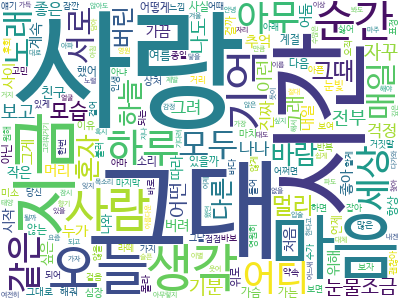

In [42]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

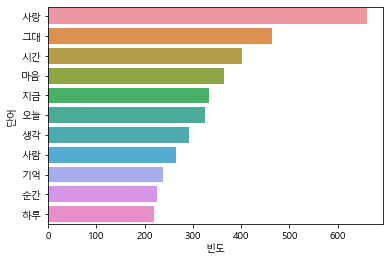

In [43]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

## 연도 칼럼 추가

In [44]:
# 1990 Top11 words
wc11['year'] = '2020y'
wc2020 = wc11
wc2020

,단어,빈도,year
2399,사랑,661,2020y
424,그대,465,2020y
2745,시간,402,2020y
1445,마음,364,2020y
4283,지금,333,2020y
3467,오늘,325,2020y
2499,생각,292,2020y
2397,사람,265,2020y
533,기억,238,2020y
2671,순간,226,2020y


---

## 2021 년도

In [45]:
# like count 정렬 맞는지 다시 확인
sort_like2021.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
16,30210331,상상더하기,라붐(LABOUM),Fresh Adventure,12992,지금 나와 어디든 가자 지루한 하루 여기까지만 작은 가방 운동화 챙겨 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '가요', '여름', '여성보컬', 'KPOP', '아이돌']",2021y
18,6065263,Celebrity,아이유(IU),IU 5th Album 'LILAC',12852,세상의 모서리 구부정하게 커버린 골칫거리 걸음걸이 옷차림 이어폰 너머 ...,https://image.bugsm.co.kr/album/images/200/402...,"['국내', '100시리즈', '2021년', '2021 뮤직PD 선곡 TOP100']",2021y


In [46]:
lyric2021 = sort_like2021.Lyric

In [47]:
tagging_okt = []
for i in lyric2021:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)

In [48]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [49]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [50]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(92214, 5000)
5000


In [51]:
cv.get_feature_names()[:10]

['가게', '가고', '가기', '가길', '가까울', '가까워', '가까워져', '가까워진', '가까이', '가끔']

In [52]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
2387,사랑,754
2735,시간,389
1489,마음,353
385,그대,315
2479,생각,312
4203,지금,293
480,기억,281
2384,사람,232
3377,오늘,226
2660,순간,209


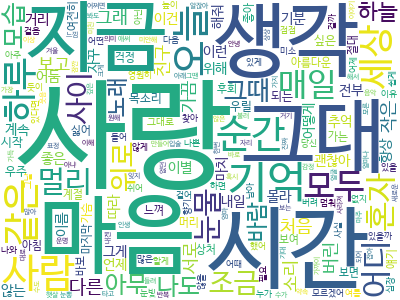

In [53]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

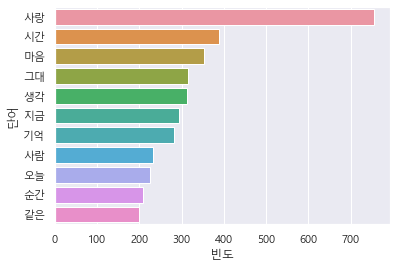

In [54]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [55]:
# 2000 Top11 words
wc11['year'] = '2021y'
wc2021 = wc11
wc2021

,단어,빈도,year
2387,사랑,754,2021y
2735,시간,389,2021y
1489,마음,353,2021y
385,그대,315,2021y
2479,생각,312,2021y
4203,지금,293,2021y
480,기억,281,2021y
2384,사람,232,2021y
3377,오늘,226,2021y
2660,순간,209,2021y


### 연대별 단어 Top11 append
* 1990년대 11개 + 2000년대 11개 + 2010년대 11개 + 2020년도 11개 + 2021년도 11개

In [58]:
top11 = pd.read_csv('top11.csv')
top11 = top11.append(wc2020)
top11 = top11.append(wc2021)

In [60]:
top11.reset_index(drop=True,inplace=True)
display(top11.head(3),top11.tail(3))

,단어,빈도,year
0,사랑,1417,1990y
1,그대,756,1990y
2,마음,437,1990y


,단어,빈도,year
52,오늘,226,2021y
53,순간,209,2021y
54,같은,200,2021y


In [61]:
len(top11) 

55

In [62]:
top11.to_csv('top11.csv',index=False)

---

### 해당 연대의 모든 곡이 아닌, Like Count 기반 Top100 곡만을 선정하여 주요 키워드를 파악한다면?

## 2020년도

In [63]:
len(sort_like2020)

612

In [64]:
sort_like2020 = sort_like2020.head(100)
lyric2020 = sort_like2020.Lyric

In [65]:
tagging_okt = []
for i in lyric2020:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)
    
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [66]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

cv.get_feature_names()[:10]

(15575, 3393)
3393


['가게', '가고', '가까워져서', '가까워질수록', '가까이', '가끔', '가나', '가난', '가네', '가는']

In [67]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1694,사랑,149
263,그대,114
1041,마음,71
1811,세상,64
2833,지금,59
1903,시간,56
1691,사람,50
555,노래,43
1758,생각,42
2191,어떤,39


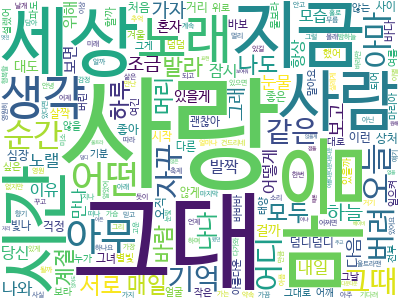

In [68]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

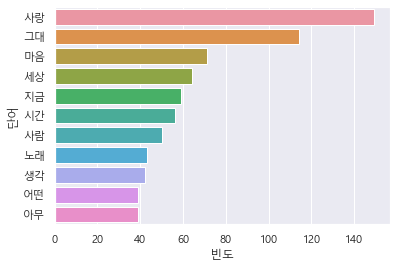

In [69]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [70]:
wc2020_100 = wc11 
wc2020_100

,단어,빈도
1694,사랑,149
263,그대,114
1041,마음,71
1811,세상,64
2833,지금,59
1903,시간,56
1691,사람,50
555,노래,43
1758,생각,42
2191,어떤,39


---

## 2021년도

In [71]:
sort_like2021 = sort_like2021.head(100)
lyric2021 = sort_like2021.Lyric

In [72]:
tagging_okt = []
for i in lyric2021:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)
    
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [73]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

cv.get_feature_names()[:10]

(16333, 3648)
3648


['가겠어', '가곤', '가길', '가까워져', '가까워지려', '가까워진', '가까웠던', '가까이', '가꾼', '가끔']

In [74]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1841,사랑,159
2063,시간,68
1839,사람,63
1122,마음,58
1905,생각,55
361,기억,49
3040,지금,47
109,같은,47
1956,세상,46
1280,모르겠어,41


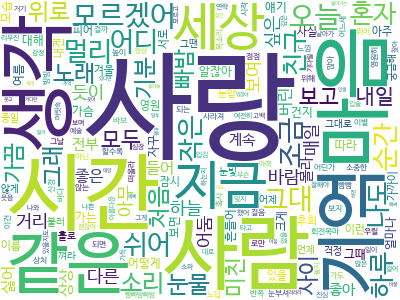

In [75]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

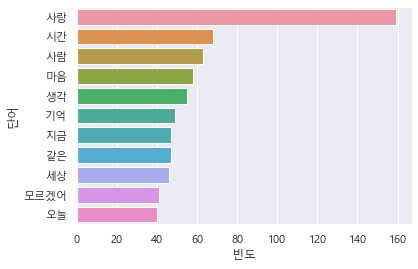

In [76]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [77]:
wc2021_100 = wc11 
wc2021_100

,단어,빈도
1841,사랑,159
2063,시간,68
1839,사람,63
1122,마음,58
1905,생각,55
361,기억,49
3040,지금,47
109,같은,47
1956,세상,46
1280,모르겠어,41


---

In [78]:
# Top11 words
wc2020_100['year'] = '2020y'
wc2021_100['year'] = '2021y'


In [79]:
top11_like100 = pd.read_csv('top11_like100.csv')

In [80]:
top11_like100 = top11_like100.append(wc2020_100)
top11_like100 = top11_like100.append(wc2021_100)
len(top11_like100)

55

In [81]:
top11_like100.to_csv('top11_like100.csv',index=False)